In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from nltk.cluster.util import cosine_distance
import string
import math
import operator
from inltk.inltk import setup
import nltk
from nltk.tokenize import SpaceTokenizer
import re
from matplotlib.font_manager import FontProperties
hindi_font=FontProperties(fname = 'Nirmala-UI.ttf')
from indicnlp.tokenize import sentence_tokenize
from inltk.inltk import get_sentence_similarity

ModuleNotFoundError: No module named 'indicnlp'

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
train_dataset=pd.read_csv('train_hindi_new.csv',nrows=200,delimiter=',')
pd.set_option('display.max_colwidth', None)

In [ ]:
def remove_redundant_sentences(sentences):
    cleaned=[]
    for s in sentences:
        if s in cleaned or s.strip()=='':
            continue
        else:
            cleaned.append(s)
    return cleaned

def clean_corpus(corpus):
    corpus=corpus.replace('।','.')
    corpus=corpus.replace('\xa0','')
    corpus=corpus.replace('\n','')
    corpus=corpus.replace('\r','')
    return corpus

def get_clean_sentences(doc):
    cleaned_doc=clean_corpus(doc)
    sentences=cleaned_doc.split('.')
    sentences=remove_redundant_sentences(sentences)
    return sentences

### <font color='blue'>Method I : Rule based extractive summarization</font>

### Scores used are the following-

#### <b>Title Score(S1)</b>- score for title words. Title words are defined as the non-stop words that occur in the title (heading) of the article. 
####            <font size=2> $$Title\:score (S1)= \frac{No.\:of\:title\:words\:in\:the\:sentence}{No.\:of\:words\:in\:the\:title}$$ </font>

#### <b>Number of words score(S2)</b> - scoring a sentence by the number of words it has.
####            <font size=2> $$No.\:of \:words\:score\:(S2) = \frac{No.\:of\:words\:in\:sentence}{No.\:of\:words\:in\:largest\:sentence}$$</font>

#### <b>English words score(S3)</b> - Common english words can be helpful in deciding importance of a sentence
####            <font size=2>$$English\:words\:score\:(S3) = \frac{No.\:of\:english\:words\:in\:sentence}{sentence\:length}$$</font>

#### <b>Numeric data score(S4)</b> - We tried to capture numerical data from the sentences. The score gives more importance to the sentence having some numerical data.
####            <font size=2>$$Numerical\:data\:score\:(S4) = \frac{No.\:of\:numerical\:figures\:in\:a\:sentence}{sentence\:length}$$</font>

#### <b>Braces/Parenthesis score(S5)</b> - Sentences may sometimes contain some information inside brackets. This information can usually be omitted without altering the meaning of the sentences.
####            <font size=2>$$Brackets\:score\:(S5) = \frac{Sentence\:Length \:-\:Total\:no\:of\:words\:within\:
brackets\:in\:sentence}{sentence\:length}$$</font>

#### <b>Keyword score(S6)</b> - In this context, keywords are defined as the words occuring with unusually high frequency. For this system, we have taken top 10% of the highest occuring words as keywords for calculating the score.
####            <font size=2>$$Keyword\:score\:(S6) = \frac{No.\:of\:keywords\:in\:sentence}{sentence\:length}$$</font>

#### <b>URL score(S7)</b> - Presence of URLs can add to the significance of a particular sentence.
####            <font size=2>$$URL\:score\:(S7) = \frac{No.\:of\:URLs\:in\:sentence}{sentence\:length}$$</font>

#### <b>Position score(S8)</b> - Sentences are assigned scores based on their relative position in the corpus. Sentences occuring in the beginning and in the end are assigned the highest score as compared to the one occuring in the middle.


In [ ]:
patternEnglish = re.compile(r'[[A-Z]|[a-z]]*')
patternNumeric = re.compile(r'.*[0-9]+')
patternBraces=re.compile(r'\[(.*?)\]|\{(.*?)\}|\((.*?)\)')
patternUrl=re.compile(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))")

def titlewordsScore(sentence,heading_titlewords):
    titlewords_sent=SpaceTokenizer().tokenize(sentence)
    titlewords_count=len(heading_titlewords)
    titlewords_sent=[word for word in titlewords_sent if word in heading_titlewords]
    s1_score=len(titlewords_sent)/titlewords_count
    return s1_score

def get_len_all_sentences(sentences):
    len_of_all_sent=[len(SpaceTokenizer().tokenize(sentence)) for sentence in sentences]
    max_length=np.max(len_of_all_sent)
    return max_length,len_of_all_sent

def searchEnglishWords(sentence):
    words=SpaceTokenizer().tokenize(sentence.strip())
    words=list(filter(None, words))
    english_words=[word for word in words if patternEnglish.match(word)!=None]
    return len(english_words)/len(words)

def positionScore(total_len):
    mid=(total_len/2)
    positions=(np.arange(total_len,mid,-1)/total_len).tolist()
    if (total_len%2==0):
        positions.extend((np.arange(mid+1,total_len+1,1)/total_len).tolist())
    else:
        positions.extend(np.arange(mid,total_len+1,1).tolist())
    return positions

def numericScore(sentence):
    words=SpaceTokenizer().tokenize(sentence)
    numbers=[1 for word in words if re.match(patternNumeric,word)]
    return np.sum(numbers)/len(words)

def bracesScore(sentence):
    t=re.findall(patternBraces,sentence)
    words=SpaceTokenizer().tokenize(sentence)
    insideTerms=()
    for term in t:
        insideTerms+=term
    insideTerms=[term for term in insideTerms if term !='']
    return (len(words)-len(insideTerms))/len(words)

def draw_zipf_distribution(sentences):
    zipf_distr={}
    for sentence in sentences:
        words=SpaceTokenizer().tokenize(sentence)
        for word in words:
            if word in zipf_distr:
                zipf_distr[word]+=1
            else:
                zipf_distr[word]=1
    fig=plt.figure(figsize=(20,20))
    plt.plot(zipf_distr.keys(),zipf_distr.values())
    plt.xticks(list(range(len(zipf_distr.keys()))), zipf_distr.keys(), color="b", fontproperties=hindi_font,rotation=45);
    plt.ylabel('Frequency')
    plt.title('Zipf Distribution')
    return zipf_distr

def keyword_score(sentences):
    zipf_distr=draw_zipf_distribution(sentences)
    keywords=[] 
    count_keywords=round(0.1*len(zipf_distr))
    keywords=[x for x,y in reversed(sorted(zipf_distr.items(), key = operator.itemgetter(1)))][:count_keywords]
    keyword_score=[]
    for sentence in sentences:
        words=SpaceTokenizer().tokenize(sentence)
        keyword_score.append(len([word for word in words if word in keywords])/len(words))
    return keyword_score
    
def url_email_score(sentence):
    words=SpaceTokenizer().tokenize(sentence.strip())
    words=list(filter(None, words))
    urls=[word for word in words if patternUrl.match(word)!=None]
    return len(urls)/len(words)

stopwords=pd.read_csv('StopwordsHindi.csv')
stopwords=list(stopwords['stopwords'])
stopwords.extend(['में','के','है','से'])

### Flow Diagram for rule based text summarisation

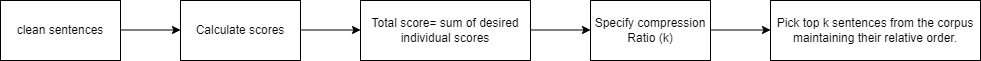

In [ ]:
def generate_summary_rule_based(clean_sentences,compression_ratio):
    score_table=pd.DataFrame(clean_sentences)
    score_table.columns=['sentence']

    headlinetokens=SpaceTokenizer().tokenize(sample['headline'])
    heading_titlewords=[ word for word in  headlinetokens if word!= '' and word not in stopwords]
    score_table['S1']=[titlewordsScore(sentence,heading_titlewords) for sentence in clean_sentences]
    max_length,len_of_all_sent=get_len_all_sentences(clean_sentences)
    score_table['S2']=[x/max_length for x in len_of_all_sent]
    score_table['S3']=[searchEnglishWords(sentence) for sentence in clean_sentences]
    score_table['S4']=[numericScore(sentence) for sentence in clean_sentences]
    score_table['S5']=[bracesScore(sentence) for sentence in clean_sentences]
    score_table['S6']=keyword_score(clean_sentences)
    score_table['S7']=[url_email_score(sentence) for sentence in clean_sentences]
    #score_table['S8']=positionScore(len(clean_sentences))
    score_table['Total']=score_table['S1']+score_table['S2']+score_table['S3']+score_table['S4']+score_table['S5']+score_table['S6']+score_table['S7']
    summary_sent_count=round(compression_ratio*len(clean_sentences))
    summary_sent=list(score_table.sort_values('Total',ascending=False).iloc[0:summary_sent_count]['sentence'])
    summary=""
    for sentence in summary_sent:
        summary+=sentence.strip()+"| "
    return summary

### <font color='blue'>Method II : Text summarization using Term frequency scores of sentences</font>

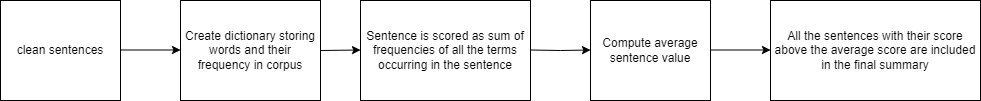

In [ ]:
from nltk.tokenize import sent_tokenize
def create_frequency_table(sentences):
    word_freq={}
    for sentence in sentences:
        words=SpaceTokenizer().tokenize(sentence)
        for word in words:
            if word in stopwords:
                continue
            if word in word_freq:
                word_freq[word]+=1
            else:
                word_freq[word]=1
    return word_freq

def score_sentences(sentences,word_freq):
    sentenceValue={}
    for sentence in sentences:
        words_in_sentence=SpaceTokenizer().tokenize(sentence)
        word_count=len(words_in_sentence)
        for word in word_freq:
            if word in words_in_sentence:
                if sentence[:10] in sentenceValue:
                    sentenceValue[sentence[:10]]+=word_freq[word]
                else:
                    sentenceValue[sentence[:10]]=word_freq[word]
        sentenceValue[sentence[:10]]=sentenceValue[sentence[:10]]/word_count
    return sentenceValue
    

def average_sentence_value(sentenceValues):
    sum_values=0
    for sent_id in sentenceValues:
        sum_values+=sentenceValues[sent_id]
    sent_count=len(sentenceValues)
    return sum_values/sent_count

def generate_summary(avg_score,sentences,sentenceValue,identifier):
    sentence_count=0
    summary=''
    for sentence in sentences:
        if sentence[:identifier] in sentenceValue and sentenceValue[sentence[:identifier]]>=avg_score:
            summary+=sentence.strip()+"| "
            sentence_count+=1
    return summary,sentence_count

In [ ]:
def summarise_term_frequency_sentence_weighing(sentences):
    word_freq_table=create_frequency_table(sentences)
    scores=score_sentences(sentences,word_freq_table)
    avg_score=average_sentence_value(scores)
    summary,sent_count=generate_summary(avg_score,sentences,scores,10)
    return summary

### <font color='blue'>Method III : Text Summarization using TF-IDF scores of sentences</font>

#### TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

#### IDF(t) = log10(Total number of documents / Number of documents with term t in it)
####  

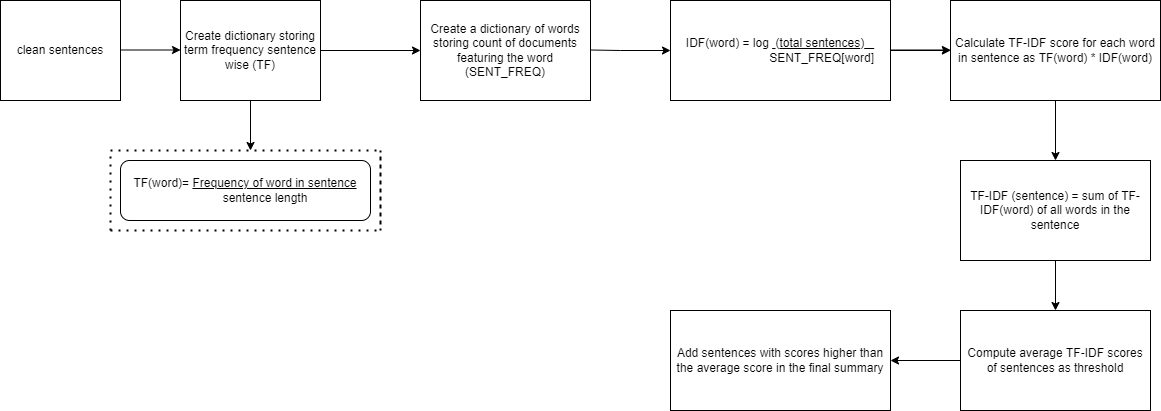


In [ ]:
def calc_term_frequency_sentence_wise(sentences):
    freq_matrix={}
    for sentence in sentences:
        words=SpaceTokenizer().tokenize(sentence)
        sent_freq_table={}
        for word in words:
            if word in stopwords:
                continue
            if word in sent_freq_table:
                sent_freq_table[word]+=1
            else:
                sent_freq_table[word]=1
        freq_matrix[sentence[:15]]=sent_freq_table
    return freq_matrix
        
def calc_tf_matrix(freq_matrix):
    for sentence,sent_freq_table in freq_matrix.items():
        tf_sent={}
        sent_len=len(sent_freq_table)
        for word in sent_freq_table:
            sent_freq_table[word]/=sent_len
    return freq_matrix

def calc_sentence_frequency(freq_matrix):
    sent_freq={}
    for sentence,freq_matrix_sent in freq_matrix.items():
        for word,count in freq_matrix_sent.items():
            if word in sent_freq:
                sent_freq[word]+=1
            else:
                sent_freq[word]=1
    return sent_freq

def calc_idf_score(total_sentences,sent_freq,freq_matrix):
    idf={}
    for sentence,freq_matrix_sent in freq_matrix.items():
        idf_sent={}
        for word in freq_matrix_sent:
            idf_sent[word]=math.log10(total_sentences / float(sent_freq[word]))
        idf[sentence]=idf_sent
    return idf
    
def calc_tf_idf_score(tf,idf):
    tf_idf={}
    for (sentence1,tf_sent),(sentence2,idf_sent) in zip(tf.items(),idf.items()):
        tf_idf_sent={}
        for (word1,tf_score),(word2,idf_score) in zip(tf_sent.items(),idf_sent.items()):
            tf_idf_sent[word1]=tf_score*idf_score
        tf_idf[sentence1]=tf_idf_sent
    return tf_idf

def calc_tf_idf_score_sentence_wise(tf_idf_matrix):
    tf_idf={}
    for sentence,tf_idf_sent in tf_idf_matrix.items():
        tf_idf_sentence=0
        for word,tf_idf_score in tf_idf_sent.items():
            tf_idf_sentence+=tf_idf_score
        tf_idf[sentence]=tf_idf_sentence
    return tf_idf

In [ ]:
def get_tf_idf(sentences):
    sent_freq_matrix=calc_term_frequency_sentence_wise(sentences)
    freq_matrix=calc_tf_matrix(sent_freq_matrix)
    total_sentences=len(sentences)
    sent_freq=calc_sentence_frequency(freq_matrix)
    idf=calc_idf_score(total_sentences,sent_freq,freq_matrix)
    tf_idf_matrix=calc_tf_idf_score(freq_matrix,idf)
    tf_idf=calc_tf_idf_score_sentence_wise(tf_idf_matrix)
    return tf_idf

def summarise_tf_idf_sentence_weighting(sentences):
    tf_idf=get_tf_idf(sentences)
    sentences=remove_redundant_sentences(sentences)
    avg_tf_idf_score=average_sentence_value(tf_idf)
    tf_idf_summary,sent_count=generate_summary(avg_tf_idf_score,sentences,tf_idf,15)
    return tf_idf_summary
    

### <font color='blue'>Method V : Text Summarization using Bag of Words(BOW) and PageRank algorithm</font>

In [ ]:
def preprocess_textrank(text):
    formatted_text = re.sub(r'\s+', ' ', text)
    formatted_text = formatted_text.lower()
    tokens = []
    for token in nltk.word_tokenize(formatted_text):
        tokens.append(token)
        tokens = [word for word in tokens if word not in stopwords and word not in string.punctuation]
        formatted_text = ' '.join(element for element in tokens)

  return formatted_text

def calculate_sentence_similarity(sentence1, sentence2):
  words1 = [word for word in nltk.word_tokenize(sentence1)]
  words2 = [word for word in nltk.word_tokenize(sentence2)]

  all_words = list(set(words1 + words2))

  vector1 = [0] * len(all_words)
  vector2 = [0] * len(all_words)

  for word in words1:
    vector1[all_words.index(word)] += 1
  for word in words2:
    vector2[all_words.index(word)] += 1

  return 1 - cosine_distance(vector1, vector2)

def calculate_similarity_matrix(sentences):
  similarity_matrix = np.zeros((len(sentences), len(sentences)))
  #print(similarity_matrix)
  for i in range(len(sentences)):
    for j in range(len(sentences)):
      if i == j:
        continue
      similarity_matrix[i][j] = calculate_sentence_similarity(sentences[i], sentences[j])
  return similarity_matrix

def print_sentence_scores(original_sentences):
    for i, score in enumerate(original_sentences):
        print(i, score)
        
def summarize(clean_sentences, percentage = 0):
  #original_sentences=sentence_tokenize.sentence_split(original_text, lang='hi')
  #formatted_sentences = [preprocess(original_sentence) for original_sentence in original_sentences]
  similarity_matrix = calculate_similarity_matrix(clean_sentences)

  similarity_graph = nx.from_numpy_array(similarity_matrix)

  scores = nx.pagerank(similarity_graph)
  ordered_scores = sorted(((scores[i], score) for i, score in enumerate(clean_sentences)), reverse=True)
  number_of_sentences=int(len(clean_sentences))
  if percentage > 0:
    number_of_sentences = int(len(clean_sentences) * percentage)

  best_sentences = []
  for sentence in range(number_of_sentences):
    best_sentences.append(ordered_scores[sentence][1])
  
  return best_sentences, ordered_scores

def generate_summary_textrank(clean_sentences,best_sentences):
    sent_dict={}
    ordered_list_of_sentences=[]
    for sent in clean_sentences:
        if sent[:15] in sent_dict:
            pass
        else:
            sent_dict[sent[:15]]=sent
            ordered_list_of_sentences.append(sent)
    summary_text=""
    for sent in ordered_list_of_sentences:
        if sent in best_sentences:
            summary_text+=sent+". "
    return summary_text


### <font color='blue'>Generating summaries from all the above methods</font>

In [ ]:
import numpy as np

In [ ]:
sample=train_dataset.iloc[15]
clean_sentences=get_clean_sentences(sample['article'])
summary_tf_idf_weight=summarise_tf_idf_sentence_weighting(clean_sentences)
summary_textrank=generate_summary_textrank(clean_sentences)

print('Summary obtained from TF-IDF scores: ',summary_tf_idf_weight,'\n')
print('Summary obtained from textrank: ',summary_textrank)

##### train_dataset